In [2]:
%load_ext autoreload
%autoreload 2

# Plot TDA vs Mix Venn Diagram as 1% FDR

In [282]:
from extract_search_result import *
from load_search_result import * 
from mixture_model import MixtureModel
from mixture_model_base import MixtureModelBase
from myutils import *
from xlms import XLMS_Dataset
register_info_dir('../results/info/')

In [143]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib_venn import venn2

## Load TDA result

In [9]:
df = load_decoy_res('alban')
df

,score_type,higher_score_better,significance_threshold,MZ,RT,spectrum_reference,xl_chain,xl_pos1,spectrum_index,xl_type,xl_rank,xl_term_spec_alpha,xl_term_spec_beta,isotope_error,score,sequence,charge,aa_before,aa_after,start,end,protein_refs,fragment_annotation,xl_mod,xl_mass,xl_pos2,precursor_mz_error_ppm,OpenPepXL:score,OpenPepXL:xquest_score,OpenPepXL:xcorr xlink,OpenPepXL:xcorr common,OpenPepXL:match-odds,OpenPepXL:intsum,OpenPepXL:intsum_alpha,OpenPepXL:intsum_beta,OpenPepXL:total_current,OpenPepXL:wTIC,OpenPepXL:TIC,OpenPepXL:prescore,OpenPepXL:log_occupancy,OpenPepXL:log_occupancy_alpha,OpenPepXL:log_occupancy_beta,matched_xlink_alpha,matched_xlink_beta,matched_linear_alpha,matched_linear_beta,ppm_error_abs_sum_linear_alpha,ppm_error_abs_sum_linear_beta,ppm_error_abs_sum_xlinks_alpha,ppm_error_abs_sum_xlinks_beta,ppm_error_abs_sum_linear,ppm_error_abs_sum_xlinks,ppm_error_abs_sum_alpha,ppm_error_abs_sum_beta,ppm_error_abs_sum,precursor_total_intensity,precursor_target_intensity,precursor_signal_proportion,precursor_target_peak_count,precursor_residual_peak_count,selected,sequence_beta,target_decoy,protein_references,xl_pos1_protein,xl_pos2_protein,accessions_beta,xl_target_decoy_alpha,xl_target_decoy_beta,delta_score
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,OpenPepXL:score,true,0.0,403.549285888671989,1531.754510525999876,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,0,5146,mono-link,1,ANYWHERE,ANYWHERE,0,0.206916506420356,K(Xlink:DSS[155])M(Oxidation)LEEIM(Oxidation)K,3,R,Y,113,120,PH_1,"130.08673095703125,0.113271534442902,1,""[alpha...",,155.094628715,-,5.623047652362637,0.206917,14.799329816441892,0.035714285714286,0.06,6.540670379111752,0.254607543349266,0.254607543349266,0.0,28.876633374020457,0.008817078502590602,0.008817078502590602,0.0,6.261729721704407,6.261729721704407,0.0,0,0,2,0,3.808223485946655,0.0,0.0,0.0,3.808223485946655,0.0,3.808223485946655,0.0,3.808223485946655,38078474.0,38078474.0,1.0,2,0,false,-,target,unique,114,-,-,target,-,0.0
1,OpenPepXL:score,true,0.0,676.317626953125,1532.620606190999979,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,13,5147,mono-link,1,ANYWHERE,ANYWHERE,4,0.29639178691169,GAGIC(Carbamidomethyl)TC(Carbamidomethyl)DWIMS...,3,R,E,2348,2363,PH_23,"175.11944580078125,8.527279831469059e-03,1,""[a...",,156.07864431,-,8.269221206834457,0.296392,35.44476371123733,0.040322580645161,0.1375,15.215917882642449,0.99181649228558,0.99181649228558,0.0,6.493932828539982,0.152729712251823,0.152729712251823,0.0,21.97885628770352,21.97885628770352,0.0,2,0,8,0,10.119914323091507,0.0,11.805193662643433,0.0,10.119914323091507,11.805193662643433,10.456970191001892,0.0,10.456970191001892,168930797.0,155311152.0,0.919377370841387,3,1,false,-,decoy,unique,2362,-,-,decoy,-,0.0
2,OpenPepXL:score,true,0.0,676.317626953125,1532.620606190999979,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,4,5147,mono-link,2,ANYWHERE,ANYWHERE,1,0.132929575704809,KQC(Carbamidomethyl)SK(Xlink:DSS[155])EDGGGWWYNR,3,R,C,421,435,PH_0,"129.102584838867188,6.403847131878138e-03,1,""[...",,155.094628715,-,5.626624486793357,0.132930,11.631505230501773,0.025423728813559,0.122222222222222,4.520585538735252,0.019674118608236,0.019674118608236,0.0,6.493932828539982,0.003029615354469197,0.003029615354469197,0.0,6.448344497504777,6.448344497504777,0.0,0,0,3,0,3.962241729100545,0.0,0.0,0.0,3.962241729100545,0.0,3.962241729100545,0.0,3.962241729100545,168930797.0,155311152.0,0.919377370841387,3,1,false,-,target,unique,426,-,-,target,-,0.0
3,OpenPepXL:score,true,0.0,676.317626953125,1532.620606190999979,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,0,5147,mono-link,3,ANYWHERE,ANYWHERE,1,0.036512947727189,K(Xlink:DSS[155])QC(Carbamidomethyl)SKEDGGGWWYNR,3,R,C,421,435,PH_0,"175.11944580078125,8.527279831469059e-03,1,""[a...",,155.094628715,-,5.626624486793357,0.036513,7.202805740064727,0.044642857142857,0.072916666666667,2.791442188809202,0.0132702714

In [ ]:
info = json.load(open('../results/info/alban.json'))

In [61]:
pd.options.mode.copy_on_write = True

In [85]:
def get_TDA_pep(df, info, fdr_thres=0.01):
    top_match = df.query('xl_rank == 1')
    
    s1 = top_match['OpenPepXL:score'].to_numpy() * 300
    
    fdr = np.interp(s1, (info['scores'][::-1]), (info['curve_fdr'][::-1]))
    
    top_match['fdr'] = fdr

    peps = top_match.query(f'fdr < {fdr_thres} and target_decoy == "target"')[['sequence', 'sequence_beta']]
    return set(peps.itertuples(index=False, name=None))

len(get_TDA_pep(df, info))


41

## Load Mix result

In [ ]:
models = pickle.load(open('../figures_python_diffsign_2S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/alban/models.pickle', 'rb'))

models = np.array(models)

dataset = XLMS_Dataset('alban')

best = reduce(max_ll, models, (0,))
frozen_model = best[()]['model']

dummy_skew = {k: 1 for k in ['C', 'IC', 'IC2', 'I1', 'I2', 'NA']}
model = MixtureModel(dummy_skew, ic2_comp=True)
model.from_frozen(frozen_model, dataset.mat.T)
model

fdr = model.fdr(s1)
plt.scatter(s1, fdr, s=1, marker='+')

In [133]:
def get_Mix2s_peps(df, model, fdr_thres=0.01):
    top_match = df.query('xl_rank == 1')
    
    s1 = top_match['OpenPepXL:score'].to_numpy() * 300
    
    fdr = model.fdr(s1)
    
    top_match['fdr'] = fdr

    peps = top_match.query(f'fdr < {fdr_thres} and target_decoy == "target"')[['sequence', 'sequence_beta']]
    return set(peps.itertuples(index=False, name=None))

len(get_Mix2s_peps(df, model))

195

## Get datasets peps

In [137]:
datasets = [
    'ALott',
    'Alinden',
    'CPSF',
    'D1810',
    'MS2000225',
    'QE',
    'RPA',
    'alban',
    'ecoli_xl',
    'peplib',
]

In [138]:
all_ids = {}

In [215]:
def get_dataset_peps(dataset_name):
    # TDA
    df_tda = load_decoy_res(dataset_name)
    info_tda = json.load(open(f'../results/info/{dataset_name}.json'))
    tda_peps = get_TDA_pep(df_tda, info_tda)

    # MIX
    df_mix = load_res(dataset_name)
    dataset = XLMS_Dataset(dataset_name)
    models = pickle.load(open(f'../figures_python_diffsign_2S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/{dataset_name}/models.pickle', 'rb'))
    best = reduce(max_ll, models, (0,))
    frozen_model = best[()]['model']
    dummy_skew = {k: 1 for k in ['C', 'IC', 'IC2', 'I1', 'I2', 'NA']}
    model = MixtureModel(dummy_skew, ic2_comp=True)
    model.from_frozen(frozen_model, dataset.mat.T)
    mix_peps = get_Mix2s_peps(df_mix, model)

    return tda_peps, mix_peps


In [216]:
for dataset_name in datasets:
    print(dataset_name)

    all_ids[dataset_name] = get_dataset_peps(dataset_name)


ALott
{'mat': array([[ 96.5485413 ,  92.97922496,  91.913342  , ..., 174.70944811,
        155.95243559,  41.12319712],
       [  0.        ,  86.91293446,  62.32423515, ..., 138.79110382,
        155.48439773,  36.44308847]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
Alinden
{'mat': array([[ 94.65938595, 115.29969757,  47.48114986, ..., 132.10294541,
        144.0833605 , 173.12160491],
       [ 94.3429953 ,  99.92061167,  47.37672058, ..., 130.95151395,
        139.6517598 , 151.4703995 ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
CPSF
{'mat': array([[124.99339504, 117.30916394,  99.68714052, ..., 108.79144509,
         95.82212858,  88.75812833],
       [121.54304036, 108.21935916,  98.14698048, ..., 104.61096083,
         85.48101457,  76.42711098]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
D1810
{'mat': array([[ 24.67499277,  67.15312977,  64.03008604, ...,  24.75380828,
         -4.765542  ,  84.53840794],
       [  4.07039486,   0.        ,  21.43503893, ..., -15.79262513,
        -19.60065632,  77.18479075]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
MS2000225
{'mat': array([[-119.8718124 ,  146.75546026,  128.91328234, ...,  127.2623007 ,
          86.21676735,  145.94841622],
       [-119.92160582,  142.63509948,  109.45333119, ...,    0.        ,
          58.84312475,  140.26210826]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
QE
{'mat': array([[ 52.67553192,  45.75587124,  26.986564  , ..., 113.24369631,
        110.46483294,  82.40845462],
       [ 47.17397786,  45.18529898,  18.05852826, ...,   0.        ,
         99.2580336 ,   0.        ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
RPA
{'mat': array([[186.09956727, 157.29701777,  78.87967609, ..., 122.80625933,
        111.58942616, 122.29122191],
       [173.89741347, 144.39228411,   0.        , ..., 120.80772894,
        108.13897455, 122.09128339]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
alban
{'mat': array([[ 62.07495193,  39.87887271, 199.56628959, ...,  79.5411614 ,
         56.71604082, 206.04280217],
       [  0.        ,  10.95388432, 190.35919864, ...,  72.006759  ,
         55.68524239, 189.2629568 ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
ecoli_xl
{'mat': array([[151.61368928, 160.92758708, 123.76551537, ...,  13.89332551,
         28.74313144,  54.9176574 ],
       [126.9950329 , 136.83976499, 119.62039244, ...,   8.65671932,
          0.        ,   0.        ]]), 'variable2': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

<Figure size 1600x900 with 0 Axes>

failed to plot fdr
peplib
{'mat': array([[139.71290565, 196.34045405, 121.74107556, ..., 135.69015612,
        111.7826202 , 112.76941546],
       [ 90.07695341, 186.13061128,  96.0243541 , ..., 124.56937649,
        110.212177  , 104.88785521]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


In [206]:
all_ids['D1810'] = get_dataset_peps('D1810')

{'mat': array([[ 24.67499277,  67.15312977,  64.03008604, ...,  24.75380828,
         -4.765542  ,  84.53840794],
       [  4.07039486,   0.        ,  21.43503893, ..., -15.79262513,
        -19.60065632,  77.18479075]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


In [257]:
all_ids['ALott'] = get_dataset_peps('ALott')

{'mat': array([[ 96.5485413 ,  92.97922496,  91.913342  , ..., 174.70944811,
        155.95243559,  41.12319712],
       [  0.        ,  86.91293446,  62.32423515, ..., 138.79110382,
        155.48439773,  36.44308847]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


In [156]:
def unfolding(*args):
    if not args:
        yield ()
        return
    arg0 = args[0]
    if not isinstance(arg0, list):
        for r in unfolding(*args[1:]):
            yield (arg0, *r)
    else:
        for x in arg0:
            for r in unfolding(*args[1:]):
                yield (x, *r)

def unfold_lists(tuples):
    res = []
    for t in tuples:
        for new in unfolding(*t):
            res.append(new)
    return res

In [157]:
def eval_first_col(tuples):
    res = []
    for t in tuples:
        newt = (eval(t[0]), t[1])
        res.append(newt)
    return res

In [158]:
unfold_lists(eval_first_col(all_ids['alban'][1]))

[('RKVIEK', 'RKVIEK'),
 ('SSSYSK(Xlink:DSS[155])QFTSSTSYNRGDSTFESK', '-'),
 ('KRKMAAWPFSR', 'KRKMAAWPFSR'),
 ('KLSFYYLIMAK', 'KLSFYYLIMAK'),
 ('K(Xlink:DSS[155])PVAFSDYIHPVC(Carbamidomethyl)LPDRETAASLLQAGYK', '-'),
 ('RLDGSVDFK(Xlink:DSS[156])K', '-'),
 ('AHYGGFTVQNEANK(Xlink:DSS[155])YQISVNKYR', '-'),
 ('NNK(Xlink:DSS[156])DSHSLTTNIM(Oxidation)EILR', '-'),
 ('M(Oxidation)ADEAGSEADHEGTHSTKR', 'M(Oxidation)ADEAGSEADHEGTHSTKR'),
 ('NIEKISMLEKIYIHPR', '-'),
 ('DYEDQQKQLEQVIAKDLLPSR', '-'),
 ('KQC(Carbamidomethyl)SK', 'KQC(Carbamidomethyl)SK'),
 ('QLEQVIAK(Xlink:DSS[155])DLLPSRDRQHLPLIK', '-'),
 ('GHRPLDKK', 'GHRPLDKK'),
 ('TVTK(Xlink:DSS[155])TVIGPDGHKEVTKEVVTSEDGSDC(Carbamidomethyl)PEAMDLGTLSGIGTLDGFR',
  '-'),
 ('SRIEVLKR', 'SRIEVLKR'),
 ('QLIK(Xlink:DSS[155])AIQLTYNPDESSKPNM(Oxidation)IDAATLK', '-'),
 ('TVTKTVIGPDGHK', 'TVTKTVIGPDGHK'),
 ('M(Oxidation)ADEAGSEADHEGTHSTK(Xlink:DSS[155])R', '-'),
 ('GSESGIFTNTK(Xlink:DSS[155])ESSSHHPGIAEFPSR', '-'),
 ('TVTK(Xlink:DSS[155])TVIGPDGHKEVTKEVV

## Fix DFs

In [226]:
dataset_name = 'ALott'
df = load_decoy_res(dataset_name)


In [227]:
df

,score_type,higher_score_better,significance_threshold,MZ,RT,spectrum_reference,xl_chain,xl_pos1,spectrum_index,xl_type,xl_rank,xl_term_spec_alpha,xl_term_spec_beta,isotope_error,score,sequence,charge,aa_before,aa_after,start,end,protein_refs,fragment_annotation,xl_mod,xl_mass,xl_pos2,precursor_mz_error_ppm,OpenPepXL:score,OpenPepXL:xquest_score,OpenPepXL:xcorr xlink,OpenPepXL:xcorr common,OpenPepXL:match-odds,OpenPepXL:intsum,OpenPepXL:intsum_alpha,OpenPepXL:intsum_beta,OpenPepXL:total_current,OpenPepXL:wTIC,OpenPepXL:TIC,OpenPepXL:prescore,OpenPepXL:log_occupancy,OpenPepXL:log_occupancy_alpha,OpenPepXL:log_occupancy_beta,matched_xlink_alpha,matched_xlink_beta,matched_linear_alpha,matched_linear_beta,ppm_error_abs_sum_linear_alpha,ppm_error_abs_sum_linear_beta,ppm_error_abs_sum_xlinks_alpha,ppm_error_abs_sum_xlinks_beta,ppm_error_abs_sum_linear,ppm_error_abs_sum_xlinks,ppm_error_abs_sum_alpha,ppm_error_abs_sum_beta,ppm_error_abs_sum,precursor_total_intensity,precursor_target_intensity,precursor_signal_proportion,precursor_target_peak_count,precursor_residual_peak_count,selected,sequence_beta,target_decoy,protein_references,xl_pos1_protein,xl_pos2_protein,accessions_beta,xl_target_decoy_alpha,xl_target_decoy_beta,delta_score
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,OpenPepXL:score,true,0.0,802.401306152343977,2614.178996393201942,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,30,7627,cross-link,1,ANYWHERE,ANYWHERE,1,0.408761606733569,TAQRQSDNFYAPVTIVANTVPYGLYAEAIEKM(Oxidation)K,7,K,T,483,515,PH_5,"147.112991333007813,0.033028457313776,1,""[alph...",DSS,138.0680796,6,0.245492421425831,0.408762,22.023923086611127,0.073770491803279,0.102459016393443,8.00952841164665,1.979811587370932,0.574451028533646,1.412083643766022,21.26174593437463,0.078695218765635,0.093116134182099,0.0,11.39364411798026,5.542394712123063,17.244893523837458,6,1,5,8,6.490994715690613,5.614615306258202,10.023808221022287,1.961363673210144,5.951684309886052,8.872030428477697,8.417983900416981,5.20869845814175,6.973805451393128,9920166.343749998,9476777.78125,0.955304321809145,7,2,false,IAETYHKM(Oxidation)AQPYDGK,decoy,unique,514,163,reverse_sp|P31948|STIP1_HUMAN,decoy,decoy,1.0
1,OpenPepXL:score,true,0.0,802.401306152343977,2614.178996393201942,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,1,7627,cross-link,2,ANYWHERE,ANYWHERE,1,0.393005948784385,M(Oxidation)KEIAEAYLGYPVTNAVITVPAYFNDSQRQATK,7,K,D,147,179,PH_0,"147.112991333007813,0.033028457313776,1,""[alph...",DSS,138.0680796,6,0.245492421750143,0.393006,19.79392959199296,0.110655737704918,0.073770491803279,7.402765108128359,1.706662513315678,0.304983073093177,1.406451093750195,21.26174593437463,0.072669467884103,0.080269161271298,0.0,9.692457500362258,2.140021476887058,17.244893523837458,7,1,2,8,2.343046247959137,5.614615306258202,11.46494916507176,1.961363673210144,4.960301494598388,10.277000978589058,9.437859627935621,5.20869845814175,7.323279043038686,9920166.343749998,9476777.78125,0.955304321809145,7,2,false,IAETYHKM(Oxidation)AQPYDGK,decoy,unique,149,163,reverse_sp|P31948|STIP1_HUMAN,target,decoy,1.0
2,OpenPepXL:score,true,0.0,802.401306152343977,2614.178996393201942,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,4,7627,cross-link,3,ANYWHERE,ANYWHERE,0,0.381960176500481,NYDGKEFYVAAQNTIYTM(Oxidation)NTPDLEKAKDYHK,7,K,L,267,297,PH_9,"147.112991333007813,0.033028457313776,1,""[alph...",DSS,138.0680796,4,1.69040735078585,0.381960,20.237333909282764,0.069672131147541,0.086065573770492,8.700338853902444,0.554683137685061,0.294445431860641,0.272540524268835,21.26174593437463,0.019966016026066,0.026088315578463,0.0,12.751665184080501,8.746317544570038,16.757012823590966,2,2,7,8,9.540151885577611,9.56933069974184,12.705963134765625,1.563148975372315,9.555713919798533,7.13455605506897,10.24366549650828,7.968094354867935,9.04599647459231,9920166.343749998,9476777.78125,0.955304321809145,7,2,false,LIGRKFGDPVVQSDMK,decoy,unique,272,98,sp|P0D

In [228]:
df.query('xl_rank == 1')

,score_type,higher_score_better,significance_threshold,MZ,RT,spectrum_reference,xl_chain,xl_pos1,spectrum_index,xl_type,xl_rank,xl_term_spec_alpha,xl_term_spec_beta,isotope_error,score,sequence,charge,aa_before,aa_after,start,end,protein_refs,fragment_annotation,xl_mod,xl_mass,xl_pos2,precursor_mz_error_ppm,OpenPepXL:score,OpenPepXL:xquest_score,OpenPepXL:xcorr xlink,OpenPepXL:xcorr common,OpenPepXL:match-odds,OpenPepXL:intsum,OpenPepXL:intsum_alpha,OpenPepXL:intsum_beta,OpenPepXL:total_current,OpenPepXL:wTIC,OpenPepXL:TIC,OpenPepXL:prescore,OpenPepXL:log_occupancy,OpenPepXL:log_occupancy_alpha,OpenPepXL:log_occupancy_beta,matched_xlink_alpha,matched_xlink_beta,matched_linear_alpha,matched_linear_beta,ppm_error_abs_sum_linear_alpha,ppm_error_abs_sum_linear_beta,ppm_error_abs_sum_xlinks_alpha,ppm_error_abs_sum_xlinks_beta,ppm_error_abs_sum_linear,ppm_error_abs_sum_xlinks,ppm_error_abs_sum_alpha,ppm_error_abs_sum_beta,ppm_error_abs_sum,precursor_total_intensity,precursor_target_intensity,precursor_signal_proportion,precursor_target_peak_count,precursor_residual_peak_count,selected,sequence_beta,target_decoy,protein_references,xl_pos1_protein,xl_pos2_protein,accessions_beta,xl_target_decoy_alpha,xl_target_decoy_beta,delta_score
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,OpenPepXL:score,true,0.0,802.401306152343977,2614.178996393201942,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,30,7627,cross-link,1,ANYWHERE,ANYWHERE,1,0.408761606733569,TAQRQSDNFYAPVTIVANTVPYGLYAEAIEKM(Oxidation)K,7,K,T,483,515,PH_5,"147.112991333007813,0.033028457313776,1,""[alph...",DSS,138.0680796,6,0.245492421425831,0.408762,22.023923086611127,0.073770491803279,0.102459016393443,8.00952841164665,1.979811587370932,0.574451028533646,1.412083643766022,21.26174593437463,0.078695218765635,0.093116134182099,0.0,11.39364411798026,5.542394712123063,17.244893523837458,6,1,5,8,6.490994715690613,5.614615306258202,10.023808221022287,1.961363673210144,5.951684309886052,8.872030428477697,8.417983900416981,5.20869845814175,6.973805451393128,9920166.343749998,9476777.78125,0.955304321809145,7,2,false,IAETYHKM(Oxidation)AQPYDGK,decoy,unique,514,163,reverse_sp|P31948|STIP1_HUMAN,decoy,decoy,1.0
10,OpenPepXL:score,true,0.0,943.128662109375,2614.703935453415852,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,7,7629,cross-link,1,ANYWHERE,ANYWHERE,3,0.41690812824797,DDSGTGDKSKSVM(Oxidation)R,3,K,A,302,315,PH_8,"130.0865478515625,0.108114704489708,1,""[beta|c...",DSS,138.0680796,2,-0.550687280711118,0.416908,21.217381116995256,0.035433070866142,0.092105263157895,8.73330363827899,1.024053981527686,0.475793464109302,0.548260517418385,25.670823730528355,0.035920087680006,0.039891746064613,0.0,11.20780351439956,8.879150695671107,13.53645633312801,3,1,3,5,3.077690402666728,3.407422947883606,14.891851743062338,15.937435150146484,3.283773243427277,15.153247594833374,8.984771072864532,5.495758314927419,7.240264693895976,3148876.09375,1087165.40625,0.34525506049852,2,6,false,VAKDNKDAEAK,decoy,unique,310,76,reverse_sp|P08238|HS90B_HUMAN,decoy,decoy,1.0
20,OpenPepXL:score,true,0.0,1061.148599999999988,2615.040561267851899,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,21,7630,cross-link,1,ANYWHERE,ANYWHERE,1,0.455557336446948,HLEINPDHPIVETLRQKAEADKNDK,5,K,A,647,671,PH_1,"130.08636474609375,0.085187569260597,1,""[alpha...",DSS,138.0680796,1,-0.042671286172303,0.455557,26.4089823090142,0.078947368421053,0.078947368421053,9.817704770689607,2.803832702338696,1.663086394321128,1.333486383877053,60.78558484092355,0.042731052935636,0.04612660566936,0.0,14.442675739184466,12.117822668351486,16.767528810017446,11,2,6,9,3.960905976593494,5.733969521191385,6.157969821583141,14.62605333328247,5.024744103352229,7.460751900306115,5.382535523351501,7.350712032480673,6.155747723366533,1332247.25,1332247.25,1.0,2,0,false,EKLAQKKNEPLDEEMPEPK,decoy,unique,669,317,reverse_sp|P31948|STIP1_HUMAN,target,decoy,1.0
30,OpenPepXL:score,true,0.0,92

In [241]:
fdr_thres = 0.01

In [242]:
top_match = df.query('xl_rank == 1')

s1 = top_match['OpenPepXL:score'].to_numpy() * 300

fdr = np.interp(s1, (info['scores'][::-1]), (info['curve_fdr'][::-1]))

top_match['fdr'] = fdr

peps = top_match.query(f'fdr < {fdr_thres} and target_decoy == "target"')[['sequence', 'sequence_beta']]
peps

,sequence,sequence_beta
,,
15999,IEDVGSDEEDDSGK(Xlink:DSS[155])DK,-
27319,EGLELPEDEEEK(Xlink:DSS[155])K,-
111146,EGLELPEDEEEK(Xlink:DSS[155])K,-
327033,HLNEIDLFHC(Carbamidomethyl)IDPNDSK(Xlink:DSS[1...,-
345154,C(Carbamidomethyl)QEVISWLDANTLAEK(Xlink:DSS[15...,-
...,...,...
3017214,GTK(Xlink:DSS[156])VILHLKEDQTEYLEER,-
3018621,K(Xlink:DSS[156])HLEINPDHPIVETLR,-
3018791,DNIK(Xlink:DSS[155])HVPGGGSVQIVYKPVDLSK,-


In [185]:
fixing_list = ['CPSF', 'MS2000225', 'RPA', 'ecoli_xl', 'peplib']

In [237]:

def fix_mix_peps(dataset_name):
    df_mix = load_res(dataset_name)
    dataset = XLMS_Dataset(dataset_name)
    models = pickle.load(open('../figures_python_diffsign_2S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/alban/models.pickle', 'rb'))
    best = reduce(max_ll, models, (0,))
    frozen_model = best[()]['model']
    dummy_skew = {k: 1 for k in ['C', 'IC', 'IC2', 'I1', 'I2', 'NA']}
    model = MixtureModel(dummy_skew, ic2_comp=True)
    model.from_frozen(frozen_model, dataset.mat.T)
    mix_peps = get_Mix2s_peps(df_mix, model)
    all_ids[dataset_name] = (all_ids[dataset_name][0], mix_peps)


In [194]:
for dataset_name in fixing_list:
    fix_mix_peps(dataset_name)

{'mat': array([[124.99339504, 117.30916394,  99.68714052, ..., 108.79144509,
         95.82212858,  88.75812833],
       [121.54304036, 108.21935916,  98.14698048, ..., 104.61096083,
         85.48101457,  76.42711098]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
{'mat': array([[-119.8718124 ,  146.75546026,  128.91328234, ...,  127.2623007 ,
          86.21676735,  145.94841622],
       [-119.92160582,  142.63509948,  109.45333119, ...,    0.        ,
          58.84312475,  140.26210826]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
{'mat': array([[186.09956727, 157.29701777,  78.87967609, ..., 122.80625933,
        111.58942616, 122.29122191],
       [173.89741347, 144.39228411,   0.        , ..., 120.80772894,
        108.13897455, 122.09128339]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr
{'mat': array([[151.61368928, 160.92758708, 123.76551537, ...,  13.89332551,
         28.74313144,  54.9176574 ],
       [126.9950329 , 136.83976499, 119.62039244, ...,   8.65671932,
          0.        ,   0.        ]]), 'variable2': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

<Figure size 1600x900 with 0 Axes>

failed to plot fdr
{'mat': array([[139.71290565, 196.34045405, 121.74107556, ..., 135.69015612,
        111.7826202 , 112.76941546],
       [ 90.07695341, 186.13061128,  96.0243541 , ..., 124.56937649,
        110.212177  , 104.88785521]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


In [238]:
fix_mix_peps('QE')

{'mat': array([[ 52.67553192,  45.75587124,  26.986564  , ..., 113.24369631,
        110.46483294,  82.40845462],
       [ 47.17397786,  45.18529898,  18.05852826, ...,   0.        ,
         99.2580336 ,   0.        ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


In [283]:
fix_mix_peps('ALott')

{'mat': array([[ 96.5485413 ,  92.97922496,  91.913342  , ..., 174.70944811,
        155.95243559,  41.12319712],
       [  0.        ,  86.91293446,  62.32423515, ..., 138.79110382,
        155.48439773,  36.44308847]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


In [289]:
fix_mix_peps('alban')

{'mat': array([[ 62.07495193,  39.87887271, 199.56628959, ...,  79.5411614 ,
         56.71604082, 206.04280217],
       [  0.        ,  10.95388432, 190.35919864, ...,  72.006759  ,
         55.68524239, 189.2629568 ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


<Figure size 1600x900 with 0 Axes>

failed to plot fdr


## Fix sets

In [291]:
for dataset_name in ['alban']:
    print(dataset_name)
    try:
        all_ids[dataset_name] = (
            unfold_lists(all_ids[dataset_name][0]),
            unfold_lists(eval_first_col(all_ids[dataset_name][1])))
    except Exception as e:
        pass

alban


In [292]:
for dataset_name in datasets:
    all_ids[dataset_name] = (
        set(all_ids[dataset_name][0]),
        set(all_ids[dataset_name][1]))


In [293]:
all_ids.keys()

dict_keys(['ALott', 'Alinden', 'CPSF', 'D1810', 'MS2000225', 'QE', 'RPA', 'alban', 'ecoli_xl', 'peplib'])

In [275]:
all_ids['alban']

({('AHYGGFTVQNEANK(Xlink:DSS[155])YQISVNK', '-'),
  ('AHYGGFTVQNEANKYQISVNK', 'SQLQKVPPEWK'),
  ('AHYGGFTVQNEANKYQISVNK(Xlink:DSS[155])YR', '-'),
  ('DNENVVNEYSSELEK(Xlink:DSS[155])HQLYIDETVNSNIPTNLR', '-'),
  ('EVTK(Xlink:DSS[155])EVVTSEDGSDC(Carbamidomethyl)PEAM(Oxidation)DLGTLSGIGTLDGFR',
   '-'),
  ('EVTK(Xlink:DSS[155])EVVTSEDGSDC(Carbamidomethyl)PEAMDLGTLSGIGTLDGFR', '-'),
  ('EVTKEVVTSEDGSDC(Carbamidomethyl)PEAMDLGTLSGIGTLDGFR', 'EYHTEKLVTSK'),
  ('GDSTFESK(Xlink:DSS[155])SYKM(Oxidation)ADEAGSEADHEGTHSTK', '-'),
  ('GDSTFESK(Xlink:DSS[155])SYKMADEAGSEADHEGTHSTK', '-'),
  ('GSESGIFTNTK(Xlink:DSS[155])ESSSHHPGIAEFPSR', '-'),
  ('HQSAC(Carbamidomethyl)K(Xlink:DSS[155])DSDWPFC(Carbamidomethyl)SDEDWNYK',
   '-'),
  ('KPDVSHGEMVSGFGPIYNYK(Xlink:DSS[155])DTIVFK', '-'),
  ('LK(Xlink:DSS[155])NSLFEYQKNNKDSHSLTTNIM(Oxidation)EILR', '-'),
  ('M(Oxidation)ADEAGSEADHEGTHSTK(Xlink:DSS[155])R', '-'),
  ('M(Oxidation)GPTELLIEM(Oxidation)EDWK(Xlink:DSS[156])GDK', '-'),
  ('M(Oxidation)GPTELLIEME

In [276]:
all_ids['ALott'][1]

{('AAAIGIDLGTTYSC(Carbamidomethyl)VGVFQHGK(Xlink:DSS[155])VEIIANDQGNR', '-'),
 ('AAAIGIDLGTTYSC(Carbamidomethyl)VGVFQHGK(Xlink:DSS[156])VEIIANDQGNR', '-'),
 ('AAALEAM(Oxidation)KDYTK', 'AAALEAM(Oxidation)KDYTK'),
 ('AAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK',
  'AAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK'),
 ('AAALEAMKDYTK', 'AAALEAMKDYTK'),
 ('AAC(Carbamidomethyl)YTK(Xlink:DSS[155])LLEFQLALK', '-'),
 ('AAC(Carbamidomethyl)YTKLLEFQLALK', 'AAC(Carbamidomethyl)YTKLLEFQLALK'),
 ('ADHGEPIGRGTKVILHLK(Xlink:DSS[155])EDQTEYLEER', '-'),
 ('ADHGEPIGRGTKVILHLKEDQTEYLEER', 'ADHGEPIGRGTKVILHLKEDQTEYLEER'),
 ('ADLINNLGTIAK(Xlink:DSS[155])SGTK', '-'),
 ('ADLINNLGTIAK(Xlink:DSS[156])SGTK', '-'),
 ('ADLINNLGTIAKSGTK', 'ADLINNLGTIAKSGTK'),
 ('AEADK(Xlink:DSS[155])NDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADK(Xlink:DSS[156])NDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDK', 'AEADKNDK'),
 ('AEADKNDK(Xlink:DSS[155])AVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDK(Xlink:DSS[156])AVKDLVVLLFETALLS

In [277]:
(all_ids['QE'][0])

{('TLDKWK(Xlink:DSS[156])RLR', '-')}

In [278]:
all_ids['ALott'][1]

{('AAAIGIDLGTTYSC(Carbamidomethyl)VGVFQHGK(Xlink:DSS[155])VEIIANDQGNR', '-'),
 ('AAAIGIDLGTTYSC(Carbamidomethyl)VGVFQHGK(Xlink:DSS[156])VEIIANDQGNR', '-'),
 ('AAALEAM(Oxidation)KDYTK', 'AAALEAM(Oxidation)KDYTK'),
 ('AAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK',
  'AAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK'),
 ('AAALEAMKDYTK', 'AAALEAMKDYTK'),
 ('AAC(Carbamidomethyl)YTK(Xlink:DSS[155])LLEFQLALK', '-'),
 ('AAC(Carbamidomethyl)YTKLLEFQLALK', 'AAC(Carbamidomethyl)YTKLLEFQLALK'),
 ('ADHGEPIGRGTKVILHLK(Xlink:DSS[155])EDQTEYLEER', '-'),
 ('ADHGEPIGRGTKVILHLKEDQTEYLEER', 'ADHGEPIGRGTKVILHLKEDQTEYLEER'),
 ('ADLINNLGTIAK(Xlink:DSS[155])SGTK', '-'),
 ('ADLINNLGTIAK(Xlink:DSS[156])SGTK', '-'),
 ('ADLINNLGTIAKSGTK', 'ADLINNLGTIAKSGTK'),
 ('AEADK(Xlink:DSS[155])NDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADK(Xlink:DSS[156])NDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDK', 'AEADKNDK'),
 ('AEADKNDK(Xlink:DSS[155])AVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDK(Xlink:DSS[156])AVKDLVVLLFETALLS

In [261]:
all_ids['ALott'][0] - all_ids['ALott'][1]

{('AAAIGIDLGTTYSC(Carbamidomethyl)VGVFQHGK(Xlink:DSS[155])VEIIANDQGNR', '-'),
 ('AEADK(Xlink:DSS[155])NDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADK(Xlink:DSS[156])NDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDK(Xlink:DSS[155])AVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDK(Xlink:DSS[156])AVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AEADKNDKAVKDLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('AK(Xlink:DSS[155])TDHGAEIVYK', '-'),
 ('ALSVGNIDDALQC(Carbamidomethyl)YSEAIK(Xlink:DSS[155])LDPHNHVLYSNR', '-'),
 ('ALSVGNIDDALQC(Carbamidomethyl)YSEAIK(Xlink:DSS[156])LDPHNHVLYSNR', '-'),
 ('APFDLFENKK(Xlink:DSS[156])KK', '-'),
 ('AVK(Xlink:DSS[155])DLVVLLFETALLSSGFSLEDPQTHSNR', '-'),
 ('C(Carbamidomethyl)GSK(Xlink:DSS[156])DNIKHVPGGGSVQIVYKPVDLSK', '-'),
 ('C(Carbamidomethyl)GSKDNIKHVPGGGSVQIVYKPVDLSK', '-'),
 ('C(Carbamidomethyl)GSLGNIHHK(Xlink:DSS[155])PGGGQVEVK', '-'),
 ('C(Carbamidomethyl)GSLGNIHHKPGGGQVEVK(Xlink:DSS[155])SEK', '-'),
 ('C(Carbamidomethyl)GSLGNIHHKPGGGQVEVK(Xlink:DSS[156])SEK'

## Plot venn diagram

In [259]:
def plot_dataset_venn(dataset_name, ax):
    set_tda, set_mix = all_ids[dataset_name]
    venn2(all_ids[dataset_name], ax=ax)

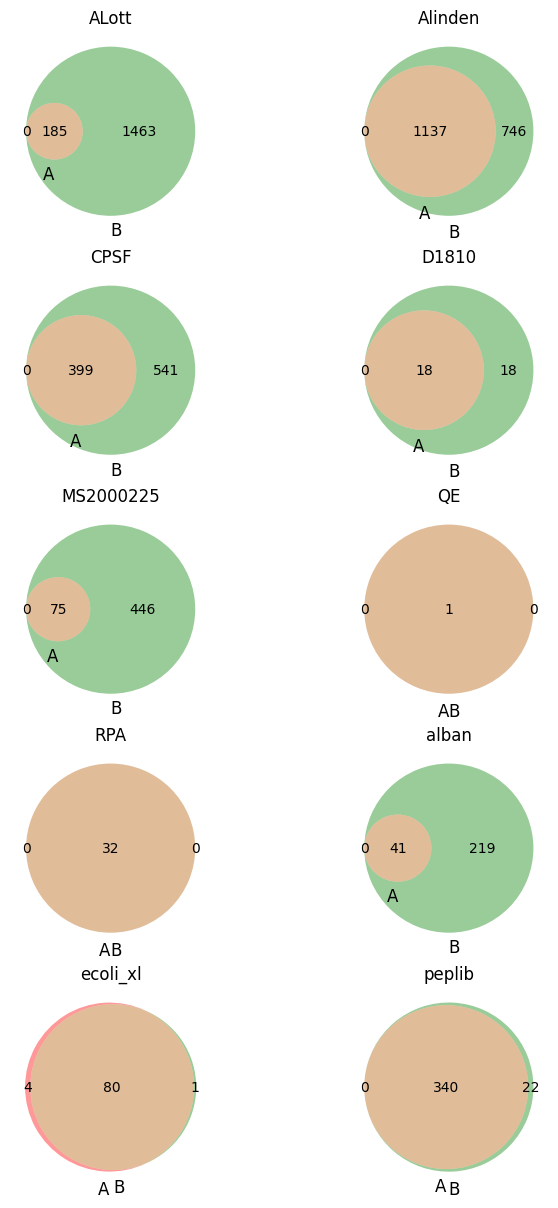

In [294]:
i = 1

fig = plt.figure(figsize=[4*2, 3*5])
for dataset_name in datasets:
    ax = plt.subplot(5, 2, i)
    plot_dataset_venn(dataset_name, ax)
    ax.set_title(dataset_name)
    i += 1

## Self-links

In [245]:
set(df['xl_type'])

{'cross-link', 'loop-link', 'mono-link'}

In [247]:
cross_links = df.query('xl_rank == 1 and xl_type == "cross-link"')

In [248]:
cross_links

,score_type,higher_score_better,significance_threshold,MZ,RT,spectrum_reference,xl_chain,xl_pos1,spectrum_index,xl_type,xl_rank,xl_term_spec_alpha,xl_term_spec_beta,isotope_error,score,sequence,charge,aa_before,aa_after,start,end,protein_refs,fragment_annotation,xl_mod,xl_mass,xl_pos2,precursor_mz_error_ppm,OpenPepXL:score,OpenPepXL:xquest_score,OpenPepXL:xcorr xlink,OpenPepXL:xcorr common,OpenPepXL:match-odds,OpenPepXL:intsum,OpenPepXL:intsum_alpha,OpenPepXL:intsum_beta,OpenPepXL:total_current,OpenPepXL:wTIC,OpenPepXL:TIC,OpenPepXL:prescore,OpenPepXL:log_occupancy,OpenPepXL:log_occupancy_alpha,OpenPepXL:log_occupancy_beta,matched_xlink_alpha,matched_xlink_beta,matched_linear_alpha,matched_linear_beta,ppm_error_abs_sum_linear_alpha,ppm_error_abs_sum_linear_beta,ppm_error_abs_sum_xlinks_alpha,ppm_error_abs_sum_xlinks_beta,ppm_error_abs_sum_linear,ppm_error_abs_sum_xlinks,ppm_error_abs_sum_alpha,ppm_error_abs_sum_beta,ppm_error_abs_sum,precursor_total_intensity,precursor_target_intensity,precursor_signal_proportion,precursor_target_peak_count,precursor_residual_peak_count,selected,sequence_beta,target_decoy,protein_references,xl_pos1_protein,xl_pos2_protein,accessions_beta,xl_target_decoy_alpha,xl_target_decoy_beta,delta_score
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,OpenPepXL:score,true,0.0,802.401306152343977,2614.178996393201942,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,30,7627,cross-link,1,ANYWHERE,ANYWHERE,1,0.408761606733569,TAQRQSDNFYAPVTIVANTVPYGLYAEAIEKM(Oxidation)K,7,K,T,483,515,PH_5,"147.112991333007813,0.033028457313776,1,""[alph...",DSS,138.0680796,6,0.245492421425831,0.408762,22.023923086611127,0.073770491803279,0.102459016393443,8.00952841164665,1.979811587370932,0.574451028533646,1.412083643766022,21.26174593437463,0.078695218765635,0.093116134182099,0.0,11.39364411798026,5.542394712123063,17.244893523837458,6,1,5,8,6.490994715690613,5.614615306258202,10.023808221022287,1.961363673210144,5.951684309886052,8.872030428477697,8.417983900416981,5.20869845814175,6.973805451393128,9920166.343749998,9476777.78125,0.955304321809145,7,2,false,IAETYHKM(Oxidation)AQPYDGK,decoy,unique,514,163,reverse_sp|P31948|STIP1_HUMAN,decoy,decoy,1.0
10,OpenPepXL:score,true,0.0,943.128662109375,2614.703935453415852,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,7,7629,cross-link,1,ANYWHERE,ANYWHERE,3,0.41690812824797,DDSGTGDKSKSVM(Oxidation)R,3,K,A,302,315,PH_8,"130.0865478515625,0.108114704489708,1,""[beta|c...",DSS,138.0680796,2,-0.550687280711118,0.416908,21.217381116995256,0.035433070866142,0.092105263157895,8.73330363827899,1.024053981527686,0.475793464109302,0.548260517418385,25.670823730528355,0.035920087680006,0.039891746064613,0.0,11.20780351439956,8.879150695671107,13.53645633312801,3,1,3,5,3.077690402666728,3.407422947883606,14.891851743062338,15.937435150146484,3.283773243427277,15.153247594833374,8.984771072864532,5.495758314927419,7.240264693895976,3148876.09375,1087165.40625,0.34525506049852,2,6,false,VAKDNKDAEAK,decoy,unique,310,76,reverse_sp|P08238|HS90B_HUMAN,decoy,decoy,1.0
20,OpenPepXL:score,true,0.0,1061.148599999999988,2615.040561267851899,file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...,MS:1002509,21,7630,cross-link,1,ANYWHERE,ANYWHERE,1,0.455557336446948,HLEINPDHPIVETLRQKAEADKNDK,5,K,A,647,671,PH_1,"130.08636474609375,0.085187569260597,1,""[alpha...",DSS,138.0680796,1,-0.042671286172303,0.455557,26.4089823090142,0.078947368421053,0.078947368421053,9.817704770689607,2.803832702338696,1.663086394321128,1.333486383877053,60.78558484092355,0.042731052935636,0.04612660566936,0.0,14.442675739184466,12.117822668351486,16.767528810017446,11,2,6,9,3.960905976593494,5.733969521191385,6.157969821583141,14.62605333328247,5.024744103352229,7.460751900306115,5.382535523351501,7.350712032480673,6.155747723366533,1332247.25,1332247.25,1.0,2,0,false,EKLAQKKNEPLDEEMPEPK,decoy,unique,669,317,reverse_sp|P31948|STIP1_HUMAN,target,decoy,1.0
30,OpenPepXL:score,true,0.0,92

In [252]:
cross_links.columns

Index(['score_type', 'higher_score_better', 'significance_threshold', 'MZ',
       'RT', 'spectrum_reference', 'xl_chain', 'xl_pos1', 'spectrum_index',
       'xl_type', 'xl_rank', 'xl_term_spec_alpha', 'xl_term_spec_beta',
       'isotope_error', 'score', 'sequence', 'charge', 'aa_before', 'aa_after',
       'start', 'end', 'protein_refs', 'fragment_annotation', 'xl_mod',
       'xl_mass', 'xl_pos2', 'precursor_mz_error_ppm', 'OpenPepXL:score',
       'OpenPepXL:xquest_score', 'OpenPepXL:xcorr xlink',
       'OpenPepXL:xcorr common', 'OpenPepXL:match-odds', 'OpenPepXL:intsum',
       'OpenPepXL:intsum_alpha', 'OpenPepXL:intsum_beta',
       'OpenPepXL:total_current', 'OpenPepXL:wTIC', 'OpenPepXL:TIC',
       'OpenPepXL:prescore', 'OpenPepXL:log_occupancy',
       'OpenPepXL:log_occupancy_alpha', 'OpenPepXL:log_occupancy_beta',
       'matched_xlink_alpha', 'matched_xlink_beta', 'matched_linear_alpha',
       'matched_linear_beta', 'ppm_error_abs_sum_linear_alpha',
       'ppm_error_ab

In [280]:
cross_links['accessions_beta']


0          reverse_sp|P31948|STIP1_HUMAN
10         reverse_sp|P08238|HS90B_HUMAN
20         reverse_sp|P31948|STIP1_HUMAN
30                 sp|P08238|HS90B_HUMAN
40         reverse_sp|P0DMV9|HS71B_HUMAN
                       ...              
3027482    reverse_sp|P08238|HS90B_HUMAN
3027492            sp|P08238|HS90B_HUMAN
3027502            sp|P31948|STIP1_HUMAN
3027512    reverse_sp|P08238|HS90B_HUMAN
3027522    reverse_sp|P08238|HS90B_HUMAN
Name: accessions_beta, Length: 305735, dtype: object

In [256]:
cross_links['protein_refs']


0          PH_5
10         PH_8
20         PH_1
30         PH_1
40         PH_6
           ... 
3027482    PH_4
3027492    PH_4
3027502    PH_4
3027512    PH_4
3027522    PH_8
Name: protein_refs, Length: 305735, dtype: object

In [258]:
import xml.etree as ET